# Project: Image Classification and Regression
### MVA

Léo Alberge

## 1) Tools and import

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import numpy.linalg as la

from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.models import Sequential
from keras.models import Model

from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout, UpSampling2D, Conv1D, Input,Concatenate
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata



def generate_a_rectangle(noise=0.0, free_location=False, return_vertices=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    if return_vertices:
        return U, V
    else:
        return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False, return_vertices=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    if return_vertices:
        return U, V
    else:
        return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False, return_vertices=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    if return_vertices:
        return U, V
    else:
        return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False, verbose=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    if verbose:
        print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            if verbose:
                print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]
 
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0, verbose=False):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    if verbose:
        print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            if verbose:
                print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_dataset_noise(nb_samples, noise=20, verbose=False, free_location=True):
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    if verbose:
        print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            if verbose:
                print(i)
        category = np.random.randint(3)
        if category == 0: 
            U,V = generate_a_rectangle(noise=0.0, free_location=free_location, return_vertices=True)
        elif category == 1: 
            U,V = generate_a_disk(noise=0.0, free_location=free_location, return_vertices=True)
        else:
            U,V = generate_a_triangle(noise=0.0, free_location=free_location, return_vertices=True)

        Y[i] = generate_a_drawing(U=U,V=V,figsize=1.0,noise=0.0)
        X[i] = generate_a_drawing(U=U,V=V,figsize=1.0,noise=20)
    Y = (Y ) / (255)
    X = (X + noise) / (255 + 2 * noise)

    return [Y, X]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()
    
def visualize(x):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    plt.show()

def visualize_vertice(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    plt.scatter(y[0], y[1])
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    plt.show()
    

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

def plot_training_error(history, batch_size=None, sgd=True):
    if sgd:
        lr, momentum, decay = history.model.optimizer.get_config()['lr'], history.model.optimizer.get_config()['momentum'], history.model.optimizer.get_config()['decay']
        label = 'SGD, LR: {0:0.2e}, Momentum: {1:0.2f}, Decay: {2:0.2e}'.format(lr, momentum, decay)
        if batch_size is not None:
            label = label + ', Bacth size {0}'.format(batch_size)
    else:
        label = ''
    plt.plot(history.history['loss'], label=label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

    

Using TensorFlow backend.


## 2) Visualize data

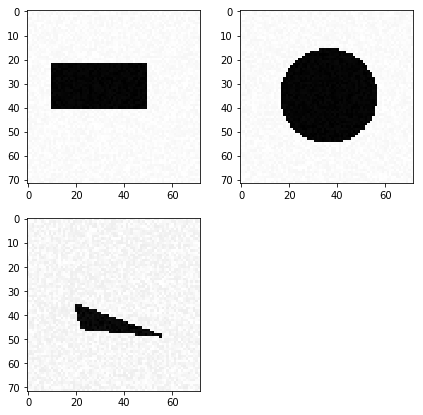

In [3]:
plt.figure(figsize=(7,7))
plt.subplot(2,2, 1)
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(2,2, 2)
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(2,2, 3)
[im, v] = generate_a_triangle(20, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

## 3) Simple classification

In this section, we will build and train a linear classifier in Keras to classify a image into one of the three possible
categories (i.e. rectangle, disk, triangle). We will try using the stochastic gradient descent optimizer, then
the Adam optimizer.

#### Generate data and visualize

In [4]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
Y_train = np_utils.to_categorical(Y_train, 3)

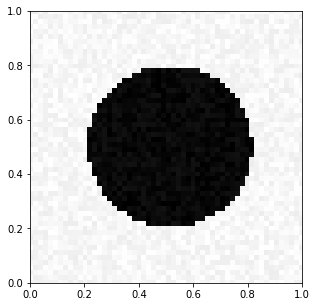

In [5]:
visualize(X_train[np.random.randint(300),:])

#### Model definition

Our model is a fully linear classifier with one dense layer and softmax activation for classification purpose.
The loss used is the categorical crossentropy.

In [6]:
# model definition 
model = Sequential()
model.add(Dense(3, activation='softmax'))

# optimizer and loss
sgd=SGD(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [7]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=10, shuffle=False)

Epoch 1/20
300/300 [==============================] - 0s 1ms/step - loss: 1.0592 - acc: 0.5033
Epoch 2/20
300/300 [==============================] - 0s 155us/step - loss: 0.8306 - acc: 0.6300
Epoch 3/20
300/300 [==============================] - 0s 172us/step - loss: 0.6969 - acc: 0.7267
Epoch 4/20
300/300 [==============================] - 0s 136us/step - loss: 0.6143 - acc: 0.7733
Epoch 5/20
300/300 [==============================] - 0s 130us/step - loss: 0.5575 - acc: 0.8233
Epoch 6/20
300/300 [==============================] - 0s 143us/step - loss: 0.5148 - acc: 0.8333
Epoch 7/20
300/300 [==============================] - 0s 130us/step - loss: 0.4809 - acc: 0.8400
Epoch 8/20
300/300 [==============================] - 0s 146us/step - loss: 0.4528 - acc: 0.8500
Epoch 9/20
300/300 [==============================] - 0s 163us/step - loss: 0.4289 - acc: 0.8567
Epoch 10/20
300/300 [==============================] - 0s 169us/step - loss: 0.4081 - acc: 0.8733
Epoch 11/20
300/300 [==========

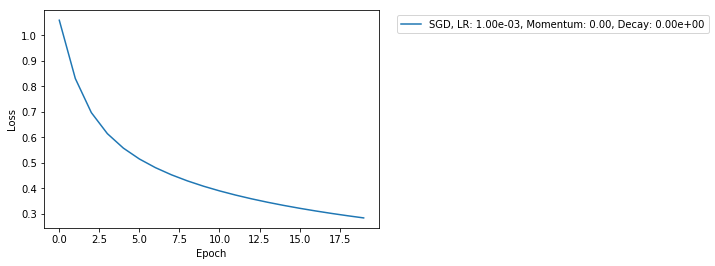

In [8]:
plot_training_error(history)

#### Test on one image

Probabilities of classes. Rectangle: 0.0, Disk: 1.0, Triangle: 0.0


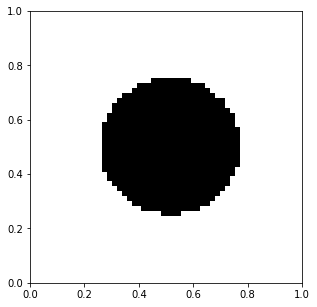

In [9]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
Y_test = model.predict_proba(X_test)
print('Probabilities of classes. Rectangle: {0}, Disk: {1}, Triangle: {2}'.format(*Y_test[0]))
visualize(X_test)

#### SGD parameters influence on training loss

Batch size

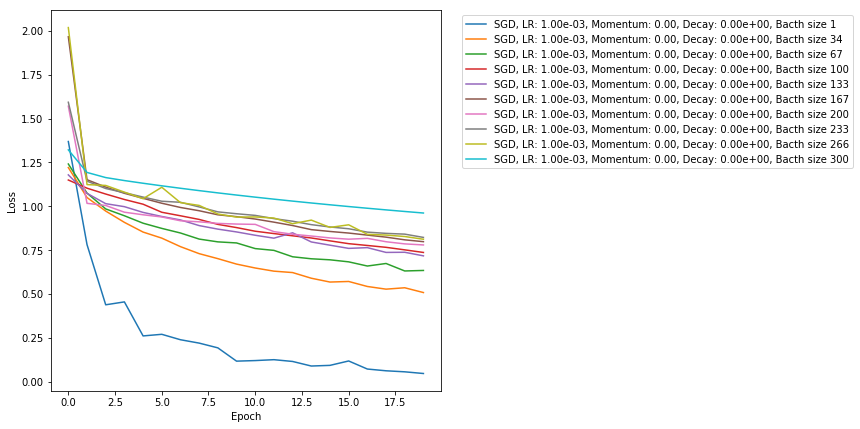

In [10]:
plt.figure(figsize=(7,7))
bacthsizes = np.linspace(1,300,10)
for batch_size in bacthsizes: 
    model = Sequential()
    model.add(Dense(3, activation='softmax'))
    sgd=SGD(lr=1e-3)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    history = model.fit(X_train, Y_train, epochs=20, batch_size=int(batch_size), verbose=False)
    plot_training_error(history, int(batch_size))

LR

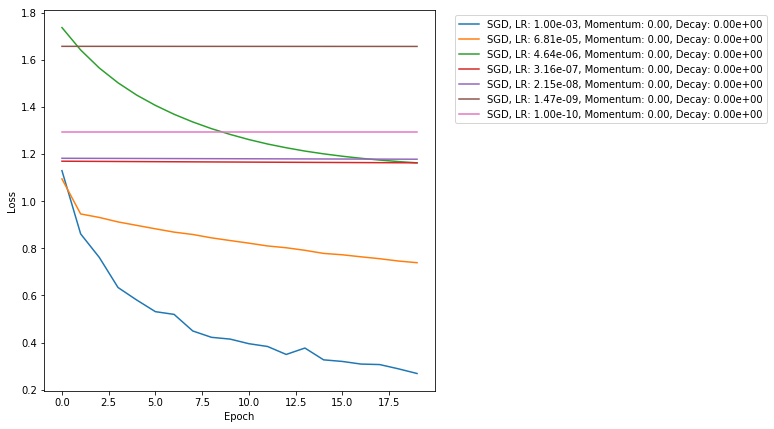

In [11]:
plt.figure(figsize=(7,7))
lrs = np.logspace(-3,-10,7)
for lr in lrs: 
    model = Sequential()
    model.add(Dense(3, activation='softmax'))
    sgd=SGD(lr=lr)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    history = model.fit(X_train, Y_train, epochs=20, batch_size=10, verbose=False)
    plot_training_error(history)

Momentum

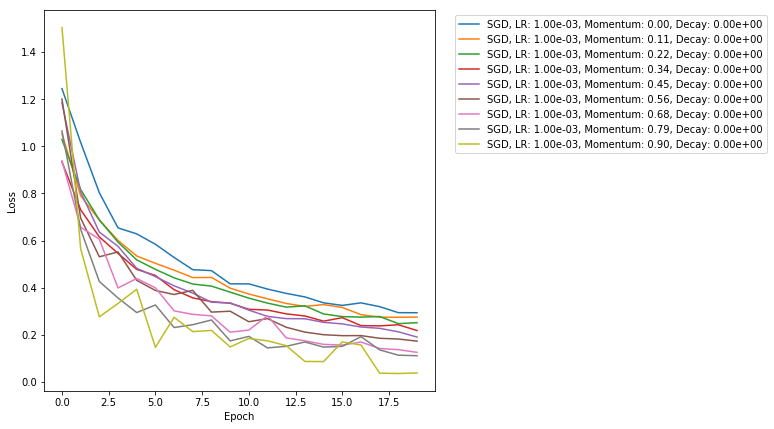

In [12]:
plt.figure(figsize=(7,7))
momentums = np.linspace(0,0.9,9)
for momentum in momentums: 
    model = Sequential()
    model.add(Dense(3, activation='softmax'))
    sgd=SGD(lr=1e-3, momentum=momentum)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    history = model.fit(X_train, Y_train, epochs=20, batch_size=10, verbose=False)
    plot_training_error(history)

#### Adam optimizer

No handles with labels found to put in legend.


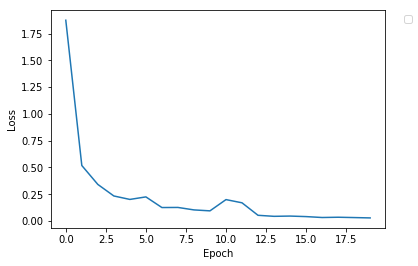

In [13]:
model = Sequential()
model.add(Dense(3, activation='softmax'))
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=20, batch_size=10, verbose=False)
plot_training_error(history, sgd=False)


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________


In [15]:
[X_test, Y_test] = generate_dataset_classification(300, 20)
Y_test = np_utils.to_categorical(Y_test, 3)

In [16]:
print('Loss: {}, Accuracy: {}'.format(*model.evaluate(X_test, Y_test)))

300/300 [==============================] - 0s 1ms/step
Loss: 0.037091028168797495, Accuracy: 1.0


## 4) Visualizing layers

We simply visualize the dense layers weights which have the same size as the input image. We can recognize the shape of the classes which corresponds to pixels that are more or less activated for the predictions.

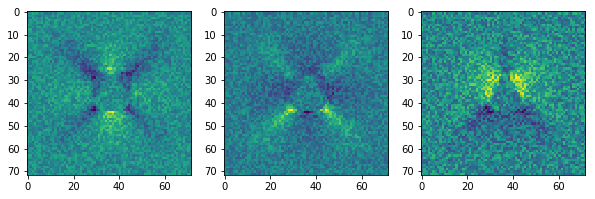

In [17]:
plt.figure(figsize=(10, 10))
plt.subplot(1,3,1)
plt.imshow(model.get_weights()[0][:,0].reshape(IMAGE_SIZE, IMAGE_SIZE))
plt.subplot(1,3,2)
plt.imshow(model.get_weights()[0][:,1].reshape(IMAGE_SIZE, IMAGE_SIZE))
plt.subplot(1,3,3)
plt.imshow(model.get_weights()[0][:,2].reshape(IMAGE_SIZE, IMAGE_SIZE))

## 5) A More Difficult Classification Problem

We first use the same network to this classification problem with free location.


In [18]:
[X_train, Y_train] = generate_dataset_classification(500, 20, True)
Y_train = np_utils.to_categorical(Y_train, 3)

In [19]:
[X_test, Y_test] = generate_test_set_classification()

In [20]:
model = Sequential()
model.add(Dense(3, activation='softmax'))
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])


In [21]:
model.fit(X_train, Y_train, epochs=20, batch_size=10)


Epoch 1/20
500/500 [==============================] - 1s 2ms/step - loss: 1.6813 - acc: 0.3700
Epoch 2/20
500/500 [==============================] - 0s 213us/step - loss: 1.3150 - acc: 0.4600
Epoch 3/20
500/500 [==============================] - 0s 233us/step - loss: 1.0822 - acc: 0.5080
Epoch 4/20
500/500 [==============================] - 0s 273us/step - loss: 1.1318 - acc: 0.4880
Epoch 5/20
500/500 [==============================] - 0s 241us/step - loss: 0.9881 - acc: 0.5540
Epoch 6/20
500/500 [==============================] - 0s 201us/step - loss: 0.9936 - acc: 0.5880
Epoch 7/20
500/500 [==============================] - 0s 231us/step - loss: 0.8457 - acc: 0.6260
Epoch 8/20
500/500 [==============================] - 0s 225us/step - loss: 0.9453 - acc: 0.5900
Epoch 9/20
500/500 [==============================] - 0s 285us/step - loss: 0.8902 - acc: 0.6160
Epoch 10/20
500/500 [==============================] - 0s 251us/step - loss: 0.9586 - acc: 0.6000
Epoch 11/20
500/500 [==========

In [22]:
print('Loss: {}, Accuracy: {}'.format(*model.evaluate(X_test, Y_test)))

300/300 [==============================] - 0s 1ms/step
Loss: 0.9183866969744364, Accuracy: 0.5766666666666667


We observe a very poor loss compared to what we have with the fixed figures.

We now train a not so deep convolutional network for the same task. The convolutional layer should improve the accuracy of the network when we move the objects on the image.

In [23]:
model = Sequential()
model.add(Reshape((IMAGE_SIZE, IMAGE_SIZE, 1), input_shape=(IMAGE_SIZE*IMAGE_SIZE,)))
model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [24]:
model.fit(X_train, Y_train, epochs=20, batch_size=10, validation_split=0.3)


Train on 350 samples, validate on 150 samples
Epoch 1/20
350/350 [==============================] - 2s 7ms/step - loss: 1.3491 - acc: 0.4057 - val_loss: 0.9988 - val_acc: 0.6000
Epoch 2/20
350/350 [==============================] - 1s 3ms/step - loss: 0.8211 - acc: 0.6629 - val_loss: 0.8311 - val_acc: 0.6200
Epoch 3/20
350/350 [==============================] - 1s 3ms/step - loss: 0.6818 - acc: 0.7229 - val_loss: 0.7630 - val_acc: 0.7333
Epoch 4/20
350/350 [==============================] - 1s 3ms/step - loss: 0.6226 - acc: 0.7543 - val_loss: 0.6962 - val_acc: 0.7267
Epoch 5/20
350/350 [==============================] - 1s 3ms/step - loss: 0.5112 - acc: 0.8114 - val_loss: 0.6721 - val_acc: 0.7600
Epoch 6/20
350/350 [==============================] - 1s 3ms/step - loss: 0.4437 - acc: 0.8571 - val_loss: 0.6726 - val_acc: 0.7333
Epoch 7/20
350/350 [==============================] - 1s 3ms/step - loss: 0.3979 - acc: 0.8857 - val_loss: 0.6396 - val_acc: 0.7533
Epoch 8/20
350/350 [==========

In [25]:
print('Loss: {}, Accuracy: {}'.format(*model.evaluate(X_test, Y_test)))

300/300 [==============================] - 0s 994us/step
Loss: 0.6041306010882059, Accuracy: 0.7666666674613952


We obtain a better loss on the test set (1.6432643922170003 compared to 0.6689332596460978).

## 6) A Regression problem

For this question, the goal is no longer classification but regression. The idea is to be able to predict the vertices locations. A major difficulty is to be able to process properly the vertices locations. Indeed, if we keep the vertices unordered there is no hope that a network could learn them(unless we change the loss maybe).
I have tried different pre-processings:
- Sorting them by the distance to the origin
- By the trigonometric order centered at the barycenter of the triangle
- By the x-asis
and I found that sorting them by an axis was giving the best results. However this preprocessing is still not satisfying for some triangles.
For this problem we use a classic architecture with a mse loss. 

In [26]:
[X_train, Y_train] = generate_dataset_regression(500, 20)

In [28]:
def order_by_x(x):
    return np.concatenate([x.reshape(3,2)[np.argsort(x.reshape(3,2)[:,0])][0,:].reshape(-1),
                           x.reshape(3,2)[np.argsort(x.reshape(3,2)[:,0])][1,:].reshape(-1),
                           x.reshape(3,2)[np.argsort(x.reshape(3,2)[:,0])][-1,:].reshape(-1)])

In [29]:
Y_train_x = np.apply_along_axis(arr=Y_train, axis=1, func1d= order_by_x)

# Visualizing some training examples

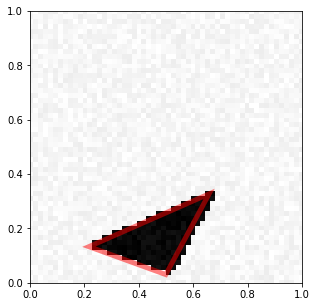

In [30]:
i = np.random.randint(300)
visualize_prediction(X_train[i], Y_train[i])

In [31]:
size_kernel = 3
model = Sequential()
model.add(Reshape((IMAGE_SIZE, IMAGE_SIZE, 1), input_shape=(IMAGE_SIZE*IMAGE_SIZE,)))
model.add(Conv2D(16, (size_kernel, size_kernel), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (size_kernel, size_kernel), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (size_kernel, size_kernel), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (size_kernel, size_kernel), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer='adam')

In [32]:
model.fit(X_train, Y_train_x, epochs=20, batch_size=10, validation_split=0.3)

Train on 350 samples, validate on 150 samples
Epoch 1/20
350/350 [==============================] - 4s 10ms/step - loss: 0.0561 - val_loss: 0.0353
Epoch 2/20
350/350 [==============================] - 2s 6ms/step - loss: 0.0318 - val_loss: 0.0275
Epoch 3/20
350/350 [==============================] - 2s 6ms/step - loss: 0.0247 - val_loss: 0.0238
Epoch 4/20
350/350 [==============================] - 2s 6ms/step - loss: 0.0203 - val_loss: 0.0197
Epoch 5/20
350/350 [==============================] - 2s 6ms/step - loss: 0.0164 - val_loss: 0.0197
Epoch 6/20
350/350 [==============================] - 2s 6ms/step - loss: 0.0142 - val_loss: 0.0158
Epoch 7/20
350/350 [==============================] - 2s 6ms/step - loss: 0.0109 - val_loss: 0.0142
Epoch 8/20
350/350 [==============================] - 2s 6ms/step - loss: 0.0087 - val_loss: 0.0128
Epoch 9/20
350/350 [==============================] - 2s 6ms/step - loss: 0.0075 - val_loss: 0.0112
Epoch 10/20
350/350 [==============================] 

In [33]:
[X_test, Y_test] = generate_test_set_regression()

In [34]:
Y_test_x = np.apply_along_axis(arr=Y_test, axis=1, func1d= order_by_x)


In [39]:
model.evaluate(X_test, Y_test_x)

300/300 [==============================] - 0s 2ms/step


0.011593238363663355

In [40]:
Y_pred = model.predict(X_test)

In [50]:
losses_test_sort = np.argsort(np.power(Y_pred - Y_test_x,2).sum(axis=1))

#### Plotting random predictions

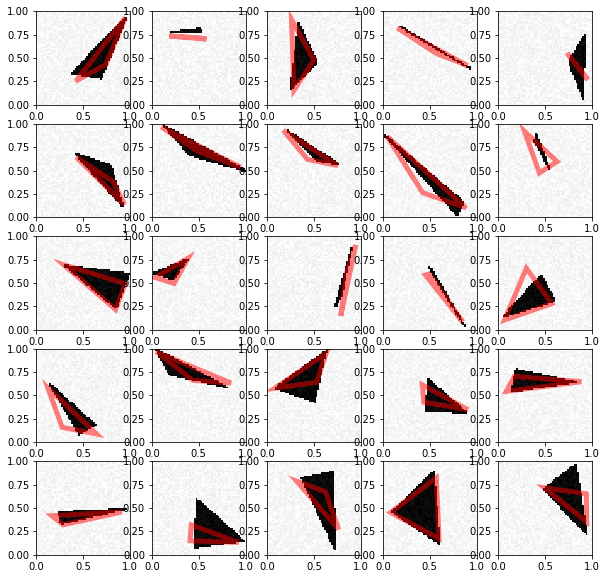

In [48]:
plt.figure(figsize=(10,10))
for i in range(25):
    ax = plt.subplot(5,5,i+1)
    x, y = X_test[i],  model.predict(X_test)[i].reshape(3,2)
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

#### Plotting best predictions

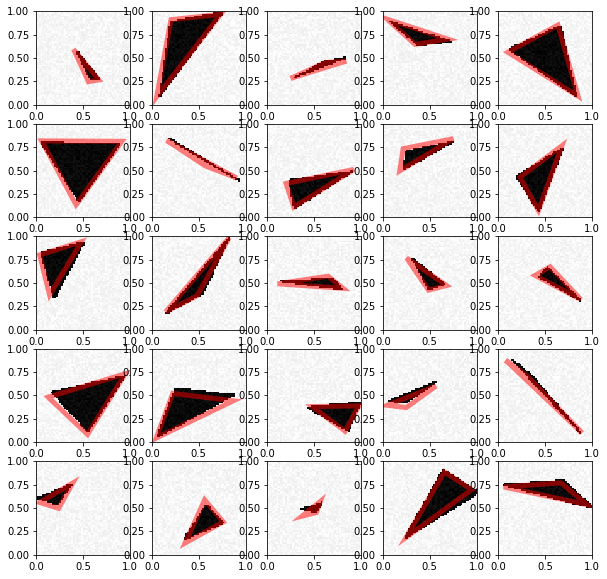

In [51]:
plt.figure(figsize=(10,10))
for i in range(25):
    ax = plt.subplot(5,5,i+1)
    x, y = X_test[losses_test_sort[i]],  Y_pred[losses_test_sort[i]].reshape(3,2)
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

#### Plotting worse cases

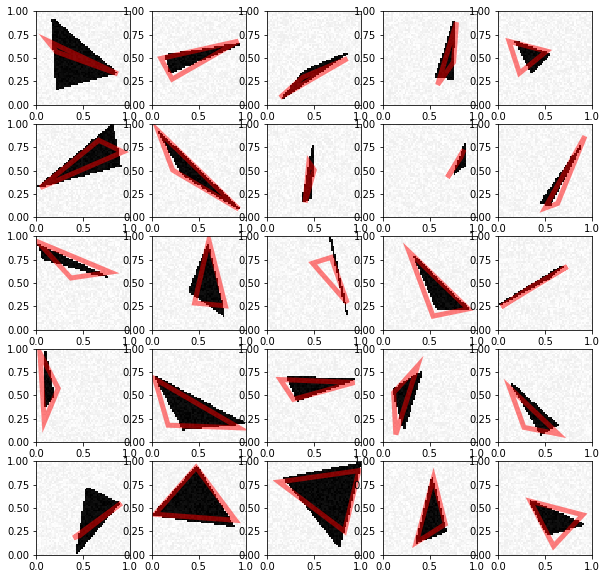

In [52]:
plt.figure(figsize=(10,10))
for i in range(25):
    ax = plt.subplot(5,5,i+1)
    x, y = X_test[-losses_test_sort[i]],  Y_pred[-losses_test_sort[i]].reshape(3,2)
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

## 7) Image Denoising

In this section, the goal is to denoise a image. For that purpose, we have modified the generating functions to create the dataset.
We are going to use a hourglass network for this purpose.

In [53]:
Y_train, X_train  = generate_dataset_noise(nb_samples=300, noise=20, verbose=False)

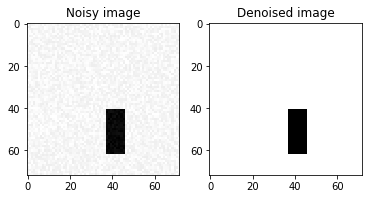

In [56]:
plt.subplot(1,2,1)
plt.title('Noisy image')
plt.imshow(X_train[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(1,2, 2)
plt.title('Denoised image')
plt.imshow(Y_train[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

#### Model definition

In [57]:
inputs = Input(shape=(5184,))
reshape = Reshape((IMAGE_SIZE, IMAGE_SIZE, 1), input_shape=(IMAGE_SIZE*IMAGE_SIZE,))(inputs)
conv1_a = Conv2D(16, 3, activation='relu', padding='same')(reshape)
conv1_b = Conv2D(16, 3, activation='relu', padding='same')(conv1_a)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_b)

conv2_a = Conv2D(32, 3, activation = 'relu',  padding='same')(pool1)
conv2_b = Conv2D(32, 3, activation = 'relu',  padding='same')(conv2_a)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_b)

conv3_a = Conv2D(64, 3, activation = 'relu',  padding='same')(pool2)
conv3_b = Conv2D(64, 3, activation = 'relu',  padding='same')(conv3_a)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_b)

up3 = UpSampling2D(size = (2,2))(pool3)
up_conv3 = Conv2D(64, 2, activation='relu', padding='same')(up3)
conv4_a = Conv2D(64, 3, activation = 'relu', padding='same')(up_conv3)
conv4_b= Conv2D(64, 3, activation = 'relu', padding='same')(conv4_a)


up2 = UpSampling2D(size = (2,2))(conv4_b)
up_conv2 = Conv2D(32, 2, activation='relu', padding='same')(up2)
merge2 = Concatenate(axis=3)([conv2_b, up_conv2])

conv5_a = Conv2D(32, 3, activation = 'relu', padding='same')(merge2)
conv5_b= Conv2D(32, 3, activation = 'relu', padding='same')(conv5_a)

up1 = UpSampling2D(size = (2,2))(conv5_b)
up_conv1 = Conv2D(16, 2, activation='relu', padding='same')(up1)
merge1 = Concatenate(axis=3)([conv1_b, up_conv1])

conv6_a = Conv2D(16, 3, activation = 'relu', padding='same')(merge1)
conv6_b= Conv2D(16, 3, activation = 'relu', padding='same')(conv6_a)

conv7 = Conv2D(1, 3, activation = 'sigmoid', padding='same')(conv6_b)
flatten = Flatten()(conv7)
model = Model(inputs=inputs, outputs = flatten)
model.compile(optimizer = 'adam',
loss = 'mse')

In [59]:
model.fit(X_train, Y_train, epochs=20, batch_size=10, validation_split=0.3)

Train on 210 samples, validate on 90 samples
Epoch 1/20
210/210 [==============================] - 18s 84ms/step - loss: 0.0745 - val_loss: 0.0389
Epoch 2/20
210/210 [==============================] - 15s 70ms/step - loss: 0.0303 - val_loss: 0.0066
Epoch 3/20
210/210 [==============================] - 15s 71ms/step - loss: 0.0199 - val_loss: 0.0067
Epoch 4/20
210/210 [==============================] - 15s 71ms/step - loss: 0.0047 - val_loss: 0.0028
Epoch 5/20
210/210 [==============================] - 15s 73ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 6/20
210/210 [==============================] - 14s 66ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/20
210/210 [==============================] - 14s 69ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 8/20
210/210 [==============================] - 14s 68ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 9/20
210/210 [==============================] - 15s 70ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/20
210/210 [================

#### Plotting predictions

In [60]:
Y_test, X_test= generate_dataset_noise(nb_samples=100, noise=20, verbose=False)

In [61]:
Y_pred = model.predict(X_test)

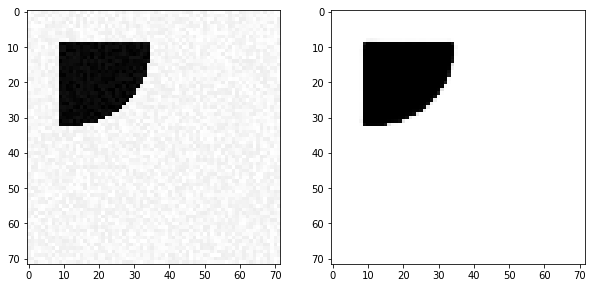

In [62]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(X_test[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(Y_pred[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

We can observe that with that level of noise, we are able to do a very good denoiser for these drawings.